In [ ]:
!pip install fastf1 scikit-learn pandas numpy --quiet
import os
import fastf1

os.makedirs("/content/f1_cache", exist_ok=True)

fastf1.Cache.enable_cache("/content/f1_cache")
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


In [ ]:
session_2024 = fastf1.get_session(2024, "Miami", "R")
session_2024.load()

laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(inplace=True)

# Convert times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()


core           INFO 	Loading data for Miami Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Miami Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data.

In [ ]:
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)


In [ ]:
clean_air_race_pace = {
    "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600, "ALO": 94.784333,
    "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444, "STR": 95.318250, "HUL": 95.345455,
    "OCO": 95.682128
}


In [ ]:
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "TSU", "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime (s)": [86.204, 86.269, 86.375, 86.385, 86.569, 86.682,
                           86.754, 86.824, 86.943, 87.006, 87.830, 87.710, 87.604, 87.473]
})

qualifying_2025["CleanAirRacePace (s)"] = qualifying_2025["Driver"].map(clean_air_race_pace)


In [ ]:
API_KEY = "4e078bd52791a7bbc6b52a90051e12f7"
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=25.7617&lon=-80.1918&appid={API_KEY}&units=metric"
response = requests.get(weather_url)
weather_data = response.json()

forecast_time = "2025-05-04 13:00:00"
forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)

rain_probability = forecast_data["pop"] if forecast_data else 0
temperature = forecast_data["main"]["temp"] if forecast_data else 20


In [ ]:
qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]  # assuming dry conditions

team_points = {
    "McLaren": 203, "Mercedes": 118, "Red Bull": 92, "Williams": 25, "Ferrari": 84,
    "Haas": 20, "Aston Martin": 14, "Kick Sauber": 6, "Racing Bulls": 8, "Alpine": 7
}
max_points = max(team_points.values())
team_performance_score = {team: pts / max_points for team, pts in team_points.items()}

driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}

qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)


In [ ]:
merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature
merged_data["LastYearWinner"] = (merged_data["Driver"] == "VER").astype(int)
merged_data["QualifyingTime"] = merged_data["QualifyingTime"] ** 2  # optional transformation

X = merged_data[["QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore", "CleanAirRacePace (s)"]]
y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])


In [ ]:
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=38)


In [ ]:
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=38)
model.fit(X_train, y_train)

merged_data["PredictedRaceTime (s)"] = model.predict(X_imputed)
final_results = merged_data.sort_values("PredictedRaceTime (s)")

print("\n Predicted 2025 Miami GP Winner \n")
print(final_results[["Driver", "PredictedRaceTime (s)"]])

y_pred = model.predict(X_test)
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")



 Predicted 2025 Miami GP Winner 

   Driver  PredictedRaceTime (s)
1     NOR              94.442128
0     VER              94.693037
2     PIA              95.497146
4     SAI              95.786589
9     HAM              95.831018
8     TSU              95.982250
12    ALO              96.024836
10    STR              96.024836
6     LEC              96.029645
3     RUS              96.125678
7     OCO              96.176589
13    HUL              96.259036
11    GAS              96.276375
5     ALB              96.821589
Model Error (MAE): 0.55 seconds


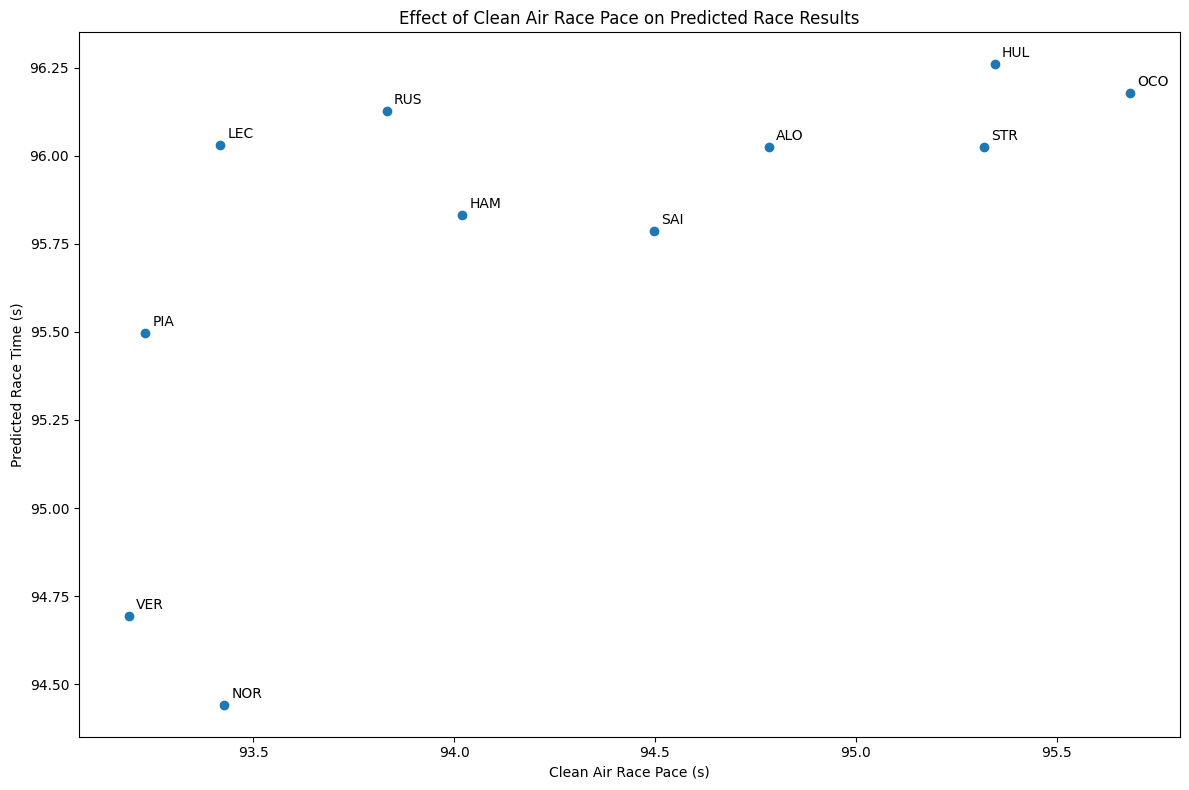

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(final_results["CleanAirRacePace (s)"], final_results["PredictedRaceTime (s)"])
for i, driver in enumerate(final_results["Driver"]):
    plt.annotate(driver, (final_results["CleanAirRacePace (s)"].iloc[i], final_results["PredictedRaceTime (s)"].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel("Clean Air Race Pace (s)")
plt.ylabel("Predicted Race Time (s)")
plt.title("Effect of Clean Air Race Pace on Predicted Race Results")
plt.tight_layout()
plt.show()


In [ ]:
driver_lap_times = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])
merged_data["LapTime (s)"] = driver_lap_times.values
merged_data["Residual"] = merged_data["LapTime (s)"] - merged_data["PredictedRaceTime (s)"]

driver_errors = merged_data.groupby("Driver")["Residual"].mean().sort_values()
print("\n Residuals (Actual - Predicted Lap Time):\n")
print(driver_errors)



📉 Residuals (Actual - Predicted Lap Time):

Driver
LEC   -1.265408e+00
NOR   -2.835248e-07
VER   -2.314536e-07
TSU   -1.390353e-07
PIA   -8.218132e-08
SAI   -7.970044e-08
HAM    5.757619e-08
OCO    5.840938e-08
RUS    1.025715e-07
HUL    1.263314e-07
GAS    1.922745e-07
ALB    2.787324e-07
ALO    1.172893e-01
STR    2.795393e-01
Name: Residual, dtype: float64


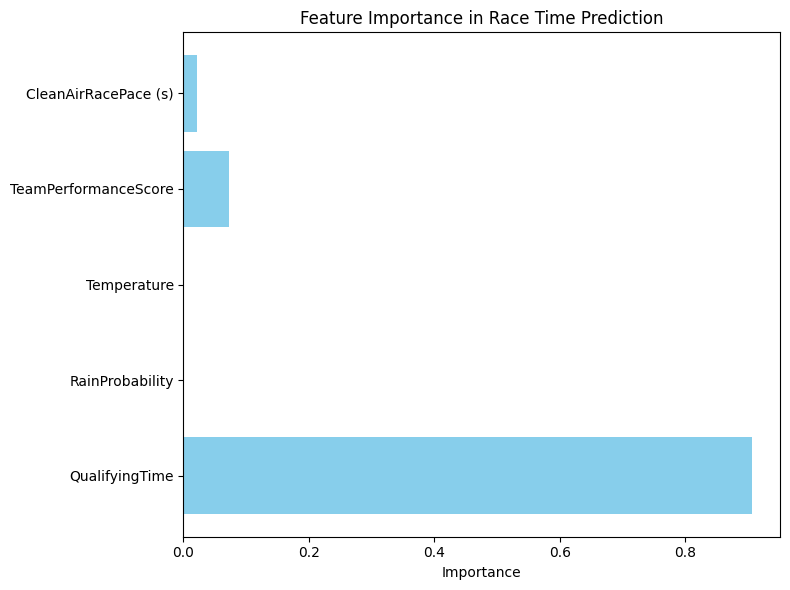

In [ ]:
feature_importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 6))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance in Race Time Prediction")
plt.tight_layout()
plt.show()
